

# What is a Predicting GDP and Inflation System?

The GDP and CPI inflation are two critical indicators that reflect the economic health and stability of the United States. GDP measures the total value of goods and services produced, representing overall economic growth, while the CPI inflation rate indicates the change in consumer prices over time, reflecting the cost of living and purchasing power. Historically, the US has experienced periods of robust GDP growth, punctuated by recessions that led to temporary declines, such as during the 2008 financial crisis and the recent COVID-19 pandemic. Despite these downturns, the US economy has demonstrated resilience with subsequent recoveries. In contrast, CPI inflation has varied, with the country experiencing high inflation rates in the 1970s and 1980s due to oil crises, followed by more stable rates in the decades that followed. However, recent years (2021–2022) have seen a resurgence in inflation, driven by supply chain disruptions, increased demand, and pandemic-related factors, reaching levels not seen in decades. This rising inflation poses challenges for economic growth, as it can erode purchasing power and increase production costs, prompting policymakers to consider tightening monetary policies to control inflation while sustaining economic growth. The interplay between GDP and inflation underscores the delicate balance needed to maintain economic stability and prosperity.

## 1. Package imports

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE





## 2. Dataset import

In [10]:
import pandas as pd

# Load the dataset
file_path = 'data/Inflation.xlsx'
data = pd.read_excel(file_path, sheet_name=None)

# Display the sheet names to understand the structure of the file
sheet_names = data.keys()
sheet_names


dict_keys(['Intro', 'top', 'hcpi_m', 'hcpi_q', 'hcpi_a', 'ecpi_m', 'ecpi_q', 'ecpi_a', 'fcpi_m', 'fcpi_q', 'fcpi_a', 'ccpi_m', 'ccpi_q', 'ccpi_a', 'ppi_m', 'ppi_q', 'ppi_a', 'def_q', 'def_a', 'Aggregate'])

In [12]:
#Reviewing hcpi_a sheet only
cpi = pd.read_excel(file_path, sheet_name='hcpi_m')

#filter the dataset for 5 countries: USA, China, Russia, Germany, India
countries_of_interest = ['United States', 'Germany', 'China', 'India', 'Russian Federation']

# Filter data for the selected countries in Food, Energy, and Core CPI datasets
cpi2 = cpi[cpi['Country'].isin(countries_of_interest)]

# Display the first few rows of each filtered dataset to verify
cpi2.head()


# Check the structure of the dataset
print('\nStructure of the dataset\n')
print(cpi2.info())

# Check for missing values
print('\nMissing value count\n')
print(cpi2.isnull().sum())

# Summary statistics for numeric features
print('\nStats about the numerical features\n')
print(cpi2.describe())

# Unique values in categorical columns
print('\nUnique value count of Categorical columns\n')
for col in cpi2.columns:
    if cpi2[col].dtype == 'object':
        print(f'{col} has {cpi2[col].nunique()} unique values')


Structure of the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 30 to 174
Columns: 655 entries, Country Code to Note
dtypes: float64(644), object(11)
memory usage: 25.6+ KB
None

Missing value count

Country Code        0
IMF Country Code    0
Country             0
Indicator Type      0
Series Name         0
                   ..
202310              1
202311              1
202312              1
Data source         0
Note                5
Length: 655, dtype: int64

Stats about the numerical features

       IMF Country Code     197001     197002     197003     197004  \
count          5.000000   3.000000   3.000000   3.000000   3.000000   
mean         525.000000  16.073075  16.122949  16.205495  16.302104   
std          400.364834  13.156751  13.189154  13.237995  13.286721   
min          111.000000   2.979196   2.979196   3.011974   3.044752   
25%          134.000000   9.463708   9.505903   9.564482   9.644156   
50%          534.000000  15.948220  16.032610  16.

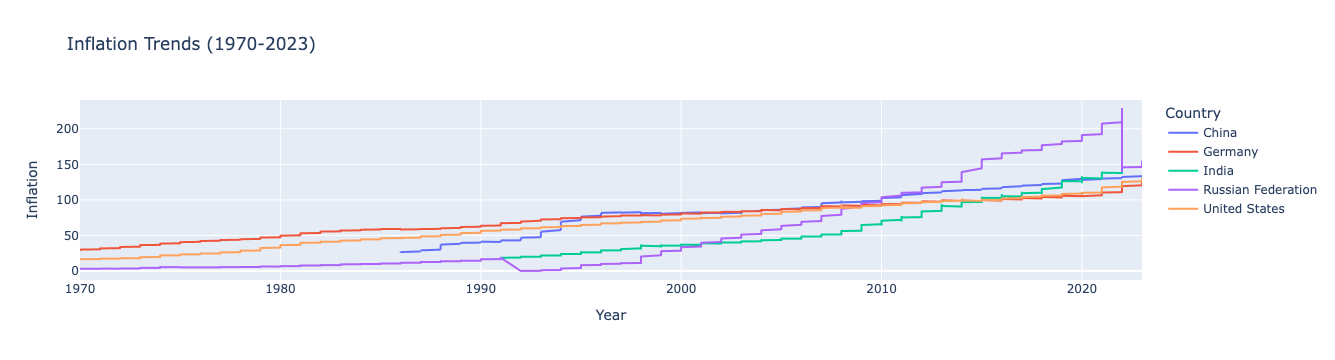

In [46]:
#Visualize the inflation rate in these countries


# Transpose the dataframe so that we can plot the years on the x-axis
years = cpi2.columns[2:-2]  # Years are from 1970 to 2023, excluding 'Note' column

# Handle missing values in the entire DataFrame
cpi2 = cpi2.ffill()  # Forward fill

# Select the top 5 countries to visualize
countries_to_plot = cpi2['Country'].head(5)



# Filter the data to only include the selected countries
data_to_plot = cpi2[cpi2['Country'].isin(countries_to_plot)]

# Reshape the data to have 'Year' as a column (melted format)
data_melted = data_to_plot.melt(id_vars=['Country'], value_vars=years, var_name='Year', value_name='Inflation')

# get rid of first few rows that don't have value under Inflation column
data_melted =data_melted.iloc[10:]


# Convert the 'Year' column to string if it's not already
data_melted['Year'] = data_melted['Year'].astype(str)

# Convert 'Year' to datetime format, specifying 'yyyyMM' format
data_melted['Year'] = pd.to_datetime(data_melted['Year'], format='%Y%m', errors='coerce')

# Extract just the year for plotting
data_melted['Year'] = data_melted['Year'].dt.year

# Plot the data using plotly.express
fig = px.line(data_melted, x='Year', y='Inflation', color='Country', title='Inflation Trends (1970-2023)')

# Show the plot
fig.show()


In [48]:


data_melted = data_melted.ffill().bfill
data_melted

,Country,Year,Inflation
10,China,1970,NaN
11,Germany,1970,29.29181
12,India,1970,2.979196
13,Russian Federation,1970,2.979196
14,United States,1970,15.94822
...,...,...,...
3245,China,2023,131.908674
3246,Germany,2023,123.7729
3247,India,2023,152.9243
3248,Russian Federation,2023,152.9243


In [60]:

# Identify and remove outliers using the Interquartile Range (IQR) method
Q1 = data_melted['Inflation'].quantile(0.25)
Q3 = data_melted['Inflation'].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for identifying outliers (1.5 times the IQR is common)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows where the inflation value is an outlier
filtered_data = data_melted[(data_melted['Inflation'] >= lower_bound) & (data_melted['Inflation'] <= upper_bound)]


#filtered_data['Year2'] = filtered_data['Year']  # Extract year from the datetime index
filtered_data = filtered_data.copy()  # Create a full copy to avoid slicing issues
filtered_data.loc[:, 'Year2'] = filtered_data['Year']
filtered_data


,Country,Year,Inflation,Year2
11,Germany,1970,29.29181,1970
12,India,1970,2.979196,1970
13,Russian Federation,1970,2.979196,1970
14,United States,1970,15.94822,1970
16,Germany,1970,29.35704,1970
...,...,...,...,...
3245,China,2023,131.908674,2023
3246,Germany,2023,123.7729,2023
3247,India,2023,152.9243,2023
3248,Russian Federation,2023,152.9243,2023


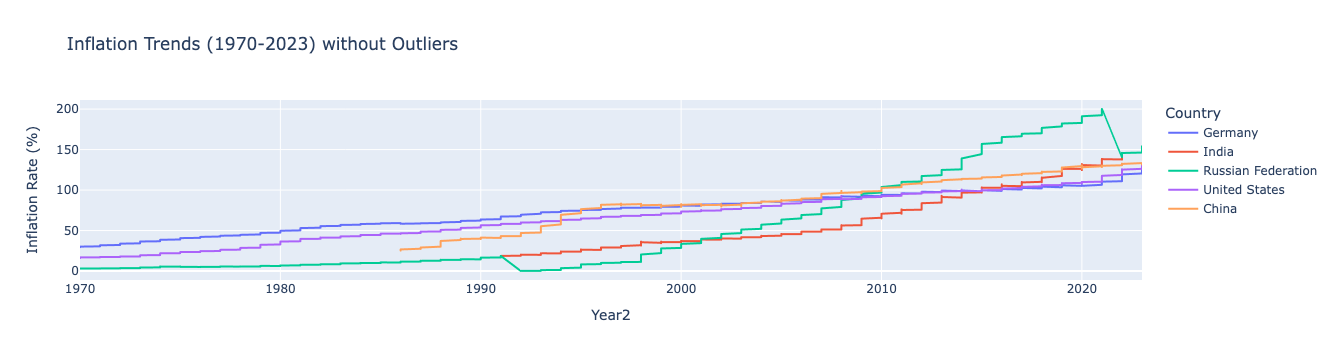

In [62]:

# Plot the data using Plotly Express without outliers
fig = px.line(filtered_data, x='Year2', y='Inflation', color='Country', title='Inflation Trends (1970-2023) without Outliers')

# Update the y-axis to be linear for better readability
fig.update_yaxes(title="Inflation Rate (%)", type='linear')

# Show the plot
fig.show()

### Overall Trend:

All countries show an upward trend in inflation over time, indicating that inflation rates have generally increased across the observed period from 1970 to 2023.
Country-Specific Observations:

### China (Orange): 
China shows a steady increase in inflation over the years but remains relatively stable compared to others.
### Germany (Blue): 
Germany has one of the lowest and most stable inflation rates over the years, indicating better control over inflation.
### India (Red): 
India has a gradual increase in inflation over time, staying within a moderate range compared to other countries.
### Russian Federation (Green): 
Russia displays sharp fluctuations, especially around the late 1980s and early 1990s, which might correspond to major economic changes like the dissolution of the Soviet Union. Afterward, inflation stabilized but still remains relatively high.
### United States (Purple): 
US displays a relatively smooth and steady increase in inflation over the years, showing consistent growth without sharp fluctuations.

### Significant Events:
The sharp dips and spikes in the Russian Federation's data around the late 1980s to early 1990s suggest significant economic disruptions, possibly due to political changes and economic reforms.
Other countries like Germany and the United States exhibit steadier trends, indicating more stable economies over the years.

### Inflation Control:
Among these countries, Germany appears to have the most effective control over inflation, as evidenced by its stable and lower inflation trend.
China and India show consistent growth in inflation, suggesting rising prices but with fewer extreme variations compared to the Russian Federation.

### Conclusion
The inflation trends indicate that while inflation has generally risen across all these countries from 1970 to 2023, some countries (e.g., Germany and the United States) have experienced more stable increases, while others like the Russian Federation have had more volatility due to economic and political changes.